<h1 style="text-align:center;font-size:30px;" > Is that a duplicate Quora question ? </h1>

<p> Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who 
contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the 
world.
</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple 
questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers
feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better
experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

# 1. Exploratory Data Analysis 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import os
import gc

import re
from nltk.corpus import stopwords as nltk_stop
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from os import path
from PIL import Image

<h2> 1.1.1 Reading The data</h2>

In [2]:
df_train= pd.read_csv("train_data.csv")
print("(1). Number of data point in train.csv:", df_train.shape[0])

(1). Number of data point in train.csv: 404290


In [3]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<p>We are given a minimal number of data fields here, consisting of:</p>

<b>id:</b> Looks like a simple rowID<br>
<b>qid{1, 2}:</b> The unique ID of each question in the pair<br>
<b>question{1, 2}:</b> The actual textual contents of the questions.<br>
<b>is_duplicate:</b> The label that we are trying to predict - whether the two questions are duplicates of each other.</p>

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<h3> 1.1.2 Checking for NULL values </h3>

In [5]:
#Checking whether there are any rows with null values
nan_rows= df_train[df_train.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\1312387298.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows= df_train[df_train.isnull().any(1)]


- We can see There are two rows with null values in question2 

In [6]:
# let's fill the null value with ''
df_train= df_train.fillna('')
nan_rows= df_train[df_train.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\3441997007.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows= df_train[df_train.isnull().any(1)]


- We can see the output of null values is fill with     '    ' 

<h3> 1.2.1 Getting Deep knowldge of Data Set </h3>

In [7]:
print("(1). Total number of question pairs for training:- {}". format(len(df_train)))
print("(2). Question pairs are not similar (is_duplicate= 0) in percentage:- {}%".format(100- round(df_train['is_duplicate'].mean()*100,2)))
print("(3). Question pairs are similar (is_duplicate= 1) in percentage:- {}%".format(round(df_train['is_duplicate'].mean()*100,2)))

(1). Total number of question pairs for training:- 404290
(2). Question pairs are not similar (is_duplicate= 0) in percentage:- 63.08%
(3). Question pairs are similar (is_duplicate= 1) in percentage:- 36.92%


- Number of duplicate(smilar) and non-duplicate(non similar) questions

<AxesSubplot: xlabel='is_duplicate'>

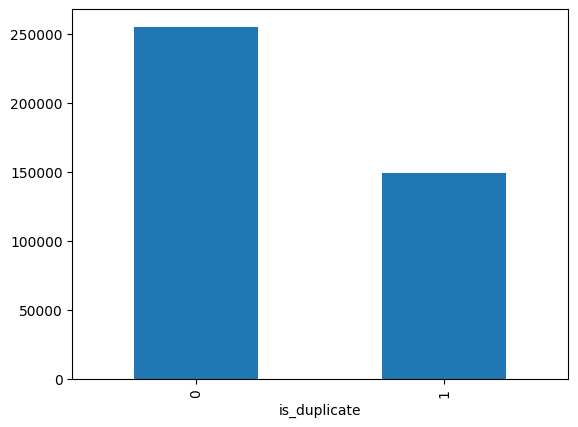

In [8]:
df_train.groupby("is_duplicate")["id"].count().plot.bar()

<h3> 1.2.2 Getting Deep knowldge about Number of unique questions </h3>

In [9]:
qids= pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
qs_uniq= len(np.unique(qids))
qs_morethan_onetime= np.sum(qids.value_counts()> 1)

print ("(1). Total number of  Unique Questions are:- {}".format(qs_uniq)) #print len(np.unique(qids))

print ("(2). Number of unique questions that appear more than one time:- {} ({}%)".format(qs_morethan_onetime,qs_morethan_onetime/qs_uniq*100))

print ("(3). Max number of times a single question is repeated:- {}".format(max(qids.value_counts()))) 
       
q_vals=qids.value_counts()

q_vals=q_vals.values

(1). Total number of  Unique Questions are:- 537933
(2). Number of unique questions that appear more than one time:- 111780 (20.77953945937505%)
(3). Max number of times a single question is repeated:- 157


<h3> 1.2.3 Ploting Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



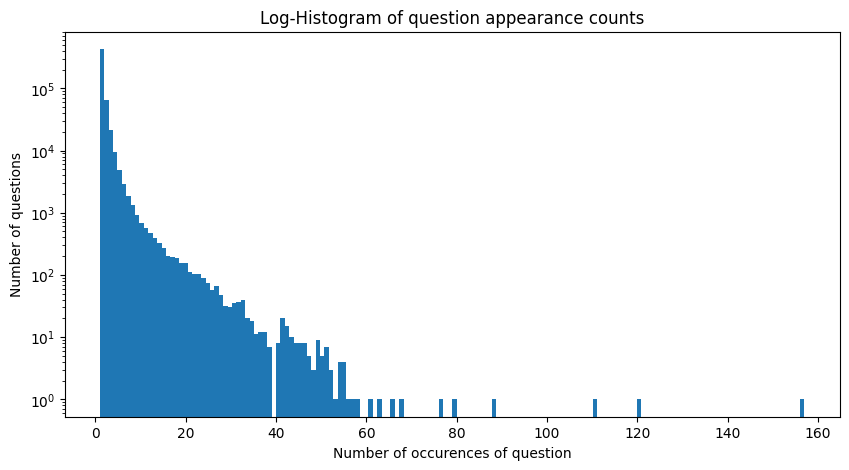

In [10]:
plt.figure(figsize=(10, 5))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<p><b>In terms of questions, Most questions only appear a few times, with very few questions appearing several times 
(and a few questions appearing many times). One question appears more than 157 times.</b></p>

<h3>1.2.4 Checking for Duplicates </h3>

In [11]:
#checking whether there are any repeated pair of questions

pair_duplicates = df_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df_train.shape[0])

Number of duplicate questions 0


<h2>1.3 Basic Feature Engineering (Feature Extraction before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [12]:
if os.path.isfile('BasicFeatures.csv'):
    df_train = pd.read_csv("BasicFeatures.csv",encoding='latin-1')
else:
    basic = pd.DataFrame()
    df_train["freq_qid1"]= df_train.groupby("qid1")["qid1"].transform("count")
    df_train["freq_qid2"]= df_train.groupby("qid2")["qid2"].transform("count")

    df_train["q1len"]= df_train["question1"].str.len()
    df_train["q2len"]= df_train["question2"].str.len()

    df_train["q1_n_words"]= df_train["question1"].apply(lambda row: len(row.split(" ")))
    df_train["q2_n_words"]= df_train["question2"].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * len(w1 & w2)
    df_train['word_Common'] = df_train.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * (len(w1) + len(w2))
    df_train['word_Total'] = df_train.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df_train['word_share'] = df_train.apply(normalized_word_share, axis=1)

    df_train['freq_q1+q2'] = df_train['freq_qid1']+df_train['freq_qid2']
    df_train['freq_q1-q2'] = abs(df_train['freq_qid1']-df_train['freq_qid2'])

    basic = df_train
    basic.drop(columns =["qid1","qid2","question1" , "question2"], inplace=True)
    basic.to_csv("BasicFeatures.csv", index=False)

basic.head()



,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 1.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [13]:
print ("Minimum length of the questions in question1 : " , min(df_train['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df_train['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df_train[df_train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df_train[df_train['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> Analysing word_share feature with ploting </h4>

C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\1988780570.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\1988780570.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974

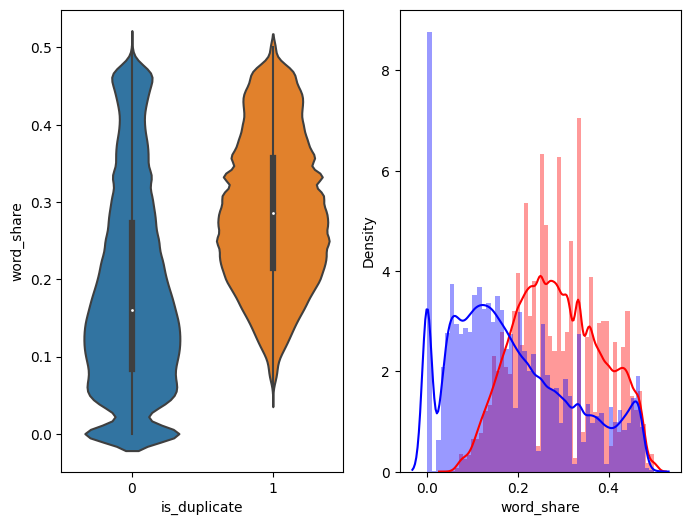

In [14]:
plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df_train[0:])

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> Analysing word_Common feature with ploting </h4>

C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\2191717200.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\2191717200.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed297

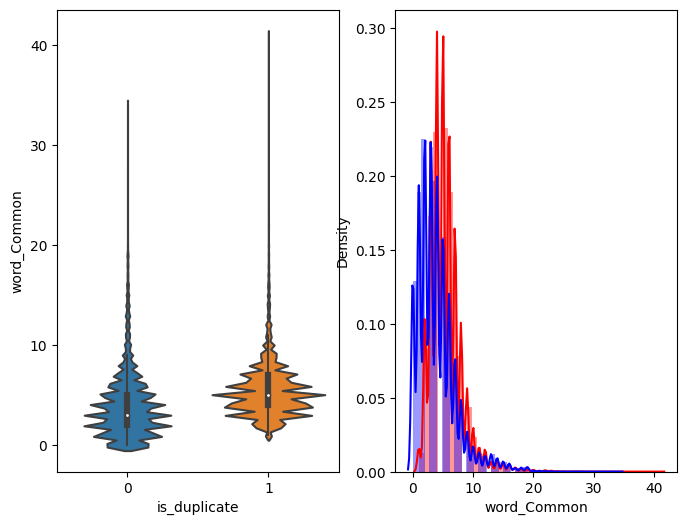

In [15]:
plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df_train[0:])

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h2> 1.4 Preprocessing of Text Data </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [16]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = set(nltk_stop.words("english"))


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

<h2> 1.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  
<br>
<br>

- __fuzz_partial_ratio__ :  
<br>
<br>


- __token_sort_ratio__ :
<br>
<br>


- __token_set_ratio__ :
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [17]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [18]:
if os.path.isfile('AdvancedFeatures.csv'):
    df = pd.read_csv("AdvancedFeatures.csv",encoding='latin-1')
    df.fillna('')
else:
    advanced = pd.DataFrame()
    print("Extracting features for train:")
    df = pd.read_csv("train_data.csv")
    df = extract_features(df)
    advanced = df.drop(columns =["qid1","qid2","question1" , "question2"])
    advanced.to_csv("AdvancedFeatures.csv", index=False)
advanced.head()

Extracting features for train:
token features...
fuzzy features..


,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


<h3>1.6 Analysis of extracted features </h3>

<h4>So what are the most common words? Let's take a look at a word cloud.</h4>

- First we creat two text files one for Duplicate_Question(Positive Class) and Non_Duplicate_Question(Negative Class) which  helps us to plot the word cloud.
- Second, Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- Third, We can observe the most frequent occuring words in both Duplicate_Question(Positive Class) and Non_Duplicate_Question(Negative Class)

In [19]:
df_duplicate= df[df["is_duplicate"]== 1]
df_nonduplicate= df[df["is_duplicate"]== 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
positive= np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
negative= np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(positive))
print ("Number of data points in class 0 (non duplicate pairs) :",len(negative))

#Saving the np array OR all the text in positive and negative class into a text file which help us to plot word cloud
np.savetxt('train_positive.txt', positive, delimiter=' ', fmt='%s', encoding= "utf-8")
np.savetxt('train_negative.txt', negative, delimiter=' ', fmt='%s', encoding= "utf-8")


Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [20]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textpositive_word = open(path.join(d, 'train_positive.txt'),encoding="utf-8").read()
textnegative_word = open(path.join(d, 'train_negative.txt'),encoding="utf-8").read()
stopwords = set(nltk_stop.words("english"))
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")

print ("Total number of words in duplicate pair questions :",len(textpositive_word))
print ("Total number of words in non duplicate pair questions :",len(textnegative_word))

Total number of words in duplicate pair questions : 16110077
Total number of words in non duplicate pair questions : 33193603


<h4> 1.6.1 Let's check out Pair plot of Advanced Feature Extraction (NLP and Fuzzy Features), features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

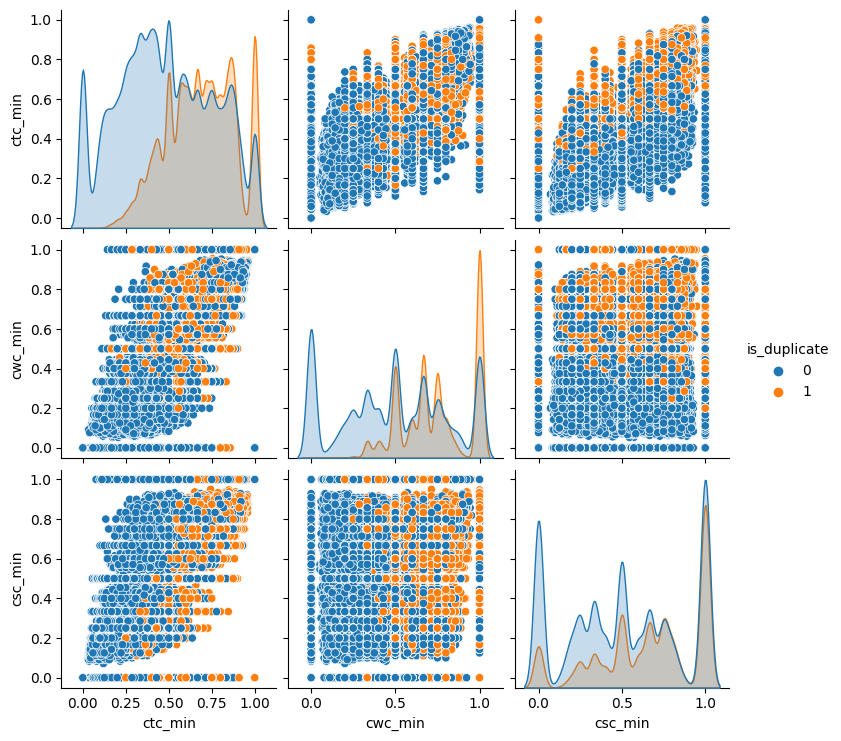

In [21]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min'])
plt.show()

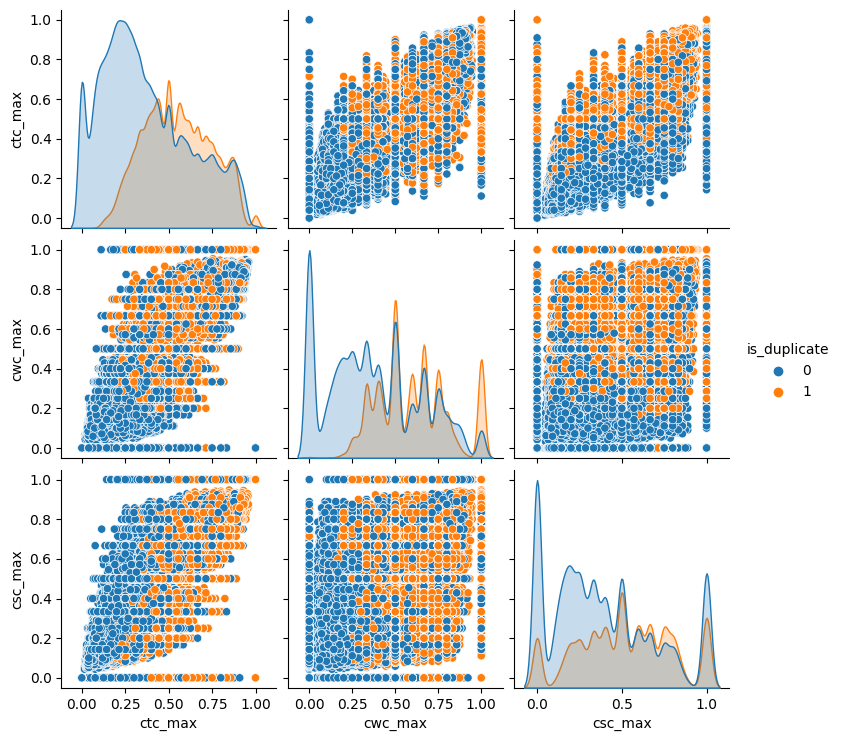

In [22]:
n = df.shape[0]
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_max', 'cwc_max', 'csc_max'])
plt.show()

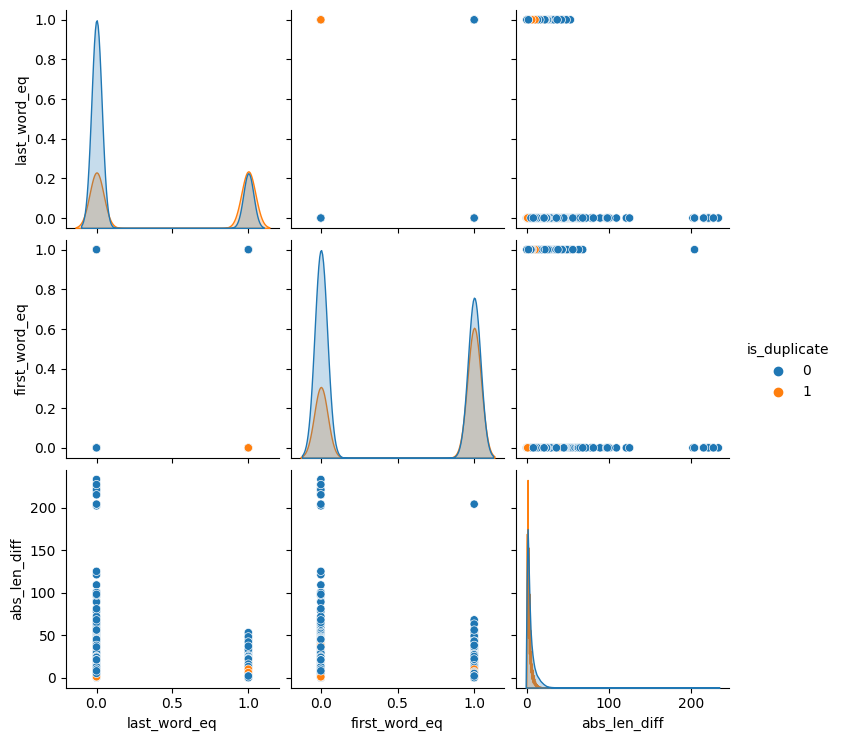

In [23]:
n = df.shape[0]
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'abs_len_diff', 'is_duplicate']][0:n], hue='is_duplicate', vars=['last_word_eq', 'first_word_eq', 'abs_len_diff'])
plt.show()

C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\1607041044.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\1607041044.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

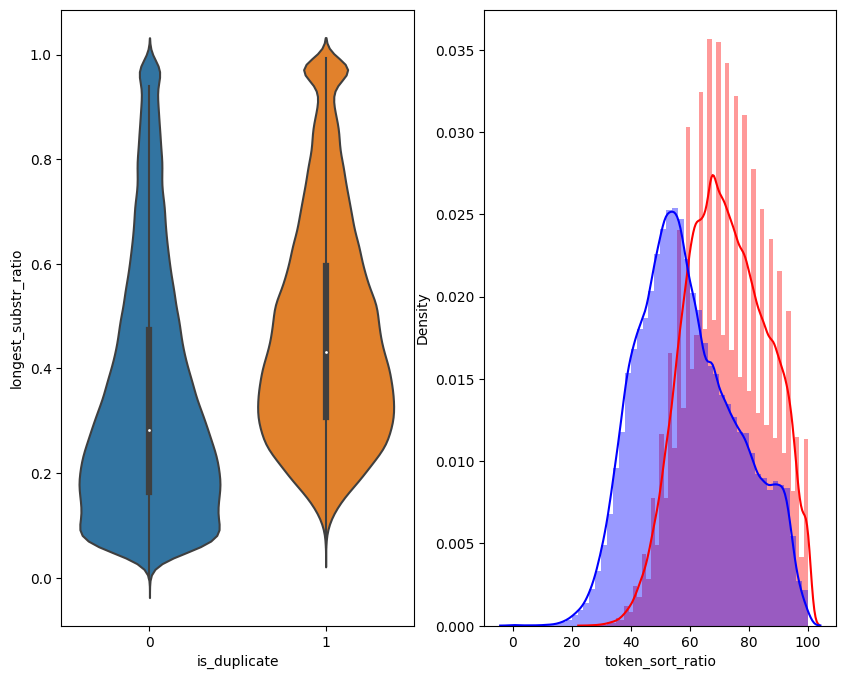

In [24]:
# Distribution of the token_sort_ratio (Univariate analysis)
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'longest_substr_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\647675072.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
C:\Users\ankesh.anupam\AppData\Local\Temp\ipykernel_18040\647675072.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bb

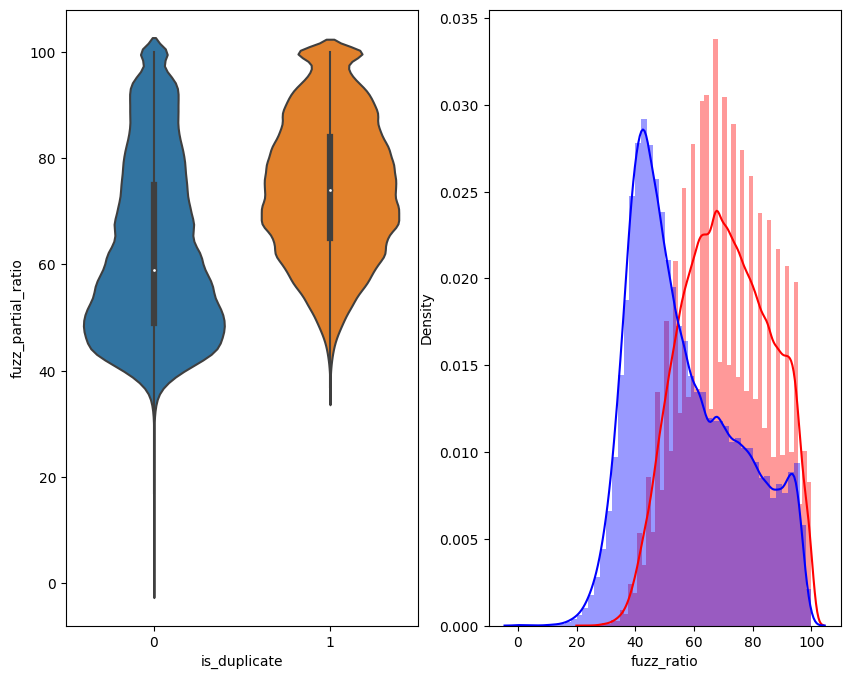

In [25]:
# Distribution of the fuzz_ratio (Univariate analysis)
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>1.6.2 TSNE Dimensionality Reduction & Visualization Visualization on Advanced Feature Extraction (NLP and Fuzzy Features) features </h3>

In [26]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimention
# class sklearn.preprocessing.MinMaxScaler(): Transform features by scaling each feature to a given range.

from sklearn.preprocessing import MinMaxScaler

df_subsampled = df[0:10000]
X = MinMaxScaler().fit_transform(df_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = df_subsampled['is_duplicate'].values

In [27]:
tsne2d= TSNE(n_components=2,init='random', random_state=101,method='barnes_hut', n_iter=1000,verbose=2, angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.027s...
[t-SNE] Computed neighbors for 10000 samples in 0.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.097852
[t-SNE] Computed conditional probabilities in 0.200s
[t-SNE] Iteration 50: error = 95.9334106, gradient norm = 0.0559207 (50 iterations in 2.247s)
[t-SNE] It

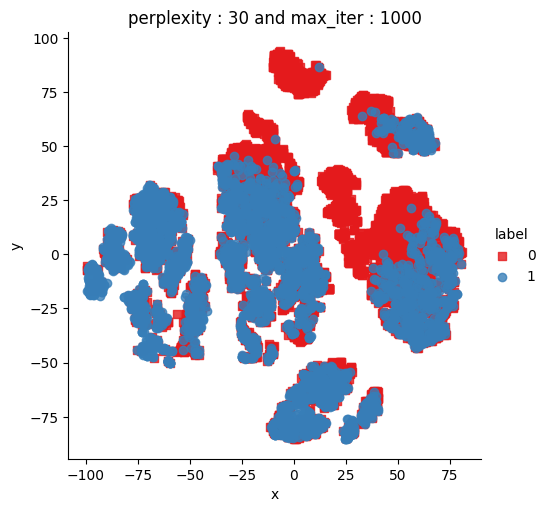

In [28]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=5,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [29]:
tsne3d= TSNE(n_components=3,init='random', random_state=101,method='barnes_hut', n_iter=1000,verbose=2, angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.039s...
[t-SNE] Computed neighbors for 10000 samples in 0.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.097852
[t-SNE] Computed conditional probabilities in 0.199s
[t-SNE] Iteration 50: error = 97.2317505, gradient norm = 0.0343202 (50 iterations in 6.392s)
[t-SNE] It

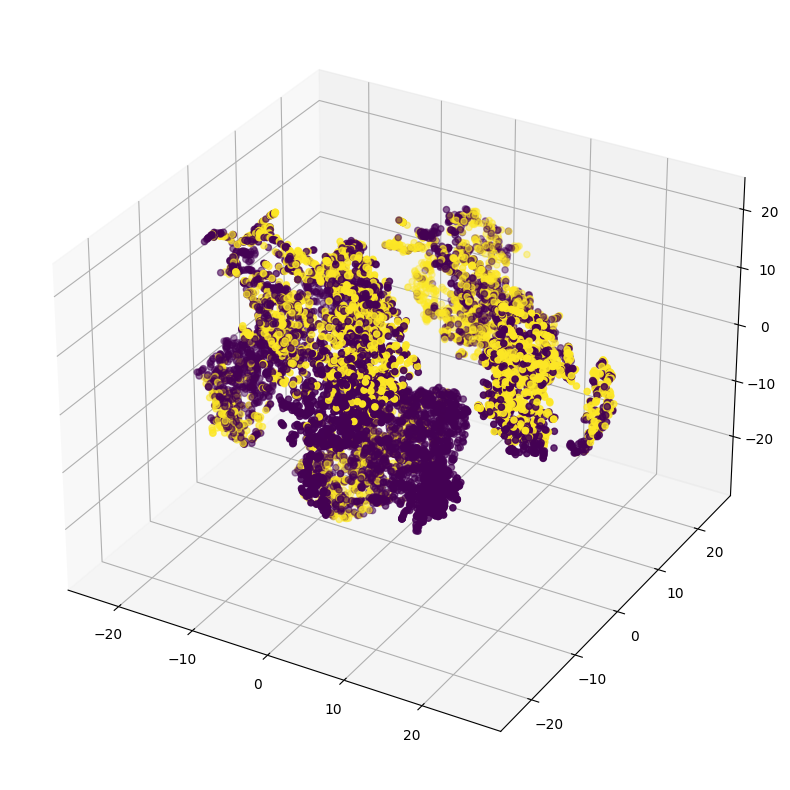

In [30]:
type(tsne3d)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne3d[:,0] , tsne3d[:,1], tsne3d[:,2], c=df_subsampled['is_duplicate'])


<h2> 1.7 Featurizing text data with tfidf weighted word-vectors </h2>

In [31]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import sys
from tqdm import tqdm
import spacy

In [32]:
# for avoid decoding problem
df= pd.read_csv("train_data.csv")

# encode questions to unicode
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [33]:
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_)) 

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- Mutiple embeddings are used to extract the embedding features

In [34]:
#nlp = spacy.load('en_core_web_sm')

import spacy
from spacy.lang.en.examples import sentences 

path = r"C:\Users\ankesh.anupam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\en_core_web_sm\en_core_web_sm-3.5.0"
nlp = spacy.load(path)

# Here I'm facing some error while i'm trying to call "en_core_web_sm" from spacy, so for that i directly copy the path and paste in load function.

vecs1 = []

# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1),len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404290/404290 [25:49<00:00, 260.90it/s]


In [35]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2),len(doc2[0].vector)])     
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404290/404290 [26:20<00:00, 255.76it/s]


In [39]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[16.463345050811768, -45.93408779799938, 9.832...","[17.591976284980774, -45.19079637527466, 5.264..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[-15.51330304145813, -26.773425683379173, 22.4...","[-22.684538774192333, -72.19047838449478, -6.7..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[-17.67637073993683, -9.333412885665894, -9.74...","[5.475004434585571, -16.17558990418911, -6.273..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[61.41019833087921, -18.52825689315796, -11.64...","[19.534104987978935, -15.777413189411163, -6.8..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[-16.9355451464653, -43.56542122364044, -0.564...","[-10.295478224754333, -31.240745186805725, 10...."


### Use the second embedding Spacy embedding "en_core_web_md"

In [41]:
path = r"C:\Users\ankesh.anupam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\en_core_web_md\en_core_web_md-3.5.0"
nlp = spacy.load(path)

vecs1 = []

# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1),len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_md'] = list(vecs1)
vecs2 = []

for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2),len(doc2[0].vector)])     
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_md'] = list(vecs2)

df.head()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404290/404290 [31:18<00:00, 215.17it/s]


,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m,q1_feats_md,q2_feats_md
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[16.463345050811768, -45.93408779799938, 9.832...","[17.591976284980774, -45.19079637527466, 5.264...","[-17.302040576934814, 65.07790648937225, -262....","[-5.95164680480957, 77.03271555900574, -248.92..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[-15.51330304145813, -26.773425683379173, 22.4...","[-22.684538774192333, -72.19047838449478, -6.7...","[-96.9532642364502, 16.185393810272217, 30.481...","[-187.34985780715942, 82.48997068405151, -82.9..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[-17.67637073993683, -9.333412885665894, -9.74...","[5.475004434585571, -16.17558990418911, -6.273...","[-48.436742186546326, 112.14766091108322, -157...","[-44.37609279155731, 148.40892499685287, 0.733..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[61.41019833087921, -18.52825689315796, -11.64...","[19.534104987978935, -15.777413189411163, -6.8...","[137.4333928823471, 79.76209062337875, -111.17...","[-130.56681299209595, -40.23609447479248, -93...."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[-16.9355451464653, -43.56542122364044, -0.564...","[-10.295478224754333, -31.240745186805725, 10....","[22.933801651000977, -110.33883082866669, -198...","[-5.494155645370483, 17.43384277820587, -121.1..."


### Use the third embedding Spacy embedding "en_core_web_lg"

In [42]:
path = r"C:\Users\ankesh.anupam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\en_core_web_lg\en_core_web_lg-3.5.0"
nlp = spacy.load(path)

vecs1 = []

# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1),len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_lg'] = list(vecs1)
vecs2 = []

for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2),len(doc2[0].vector)])     
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_lg'] = list(vecs2)

df.head()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404290/404290 [32:07<00:00, 209.77it/s]


,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m,q1_feats_md,q2_feats_md,q1_feats_lg,q2_feats_lg
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[16.463345050811768, -45.93408779799938, 9.832...","[17.591976284980774, -45.19079637527466, 5.264...","[-17.302040576934814, 65.07790648937225, -262....","[-5.95164680480957, 77.03271555900574, -248.92...","[-17.302040576934814, 65.07790648937225, -262....","[-5.95164680480957, 77.03271555900574, -248.92..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[-15.51330304145813, -26.773425683379173, 22.4...","[-22.684538774192333, -72.19047838449478, -6.7...","[-96.9532642364502, 16.185393810272217, 30.481...","[-187.34985780715942, 82.48997068405151, -82.9...","[-21.27127695083618, 42.34149789810181, 84.177...","[-111.66787052154541, 108.6460747718811, -29.2..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[-17.67637073993683, -9.333412885665894, -9.74...","[5.475004434585571, -16.17558990418911, -6.273...","[-48.436742186546326, 112.14766091108322, -157...","[-44.37609279155731, 148.40892499685287, 0.733...","[-48.436742186546326, 112.14766091108322, -157...","[-29.703657031059265, 19.86686795949936, -63.5..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[61.41019833087921, -18.52825689315796, -11.64...","[19.534104987978935, -15.777413189411163, -6.8...","[137.4333928823471, 79.76209062337875, -111.17...","[-130.56681299209595, -40.23609447479248, -93....","[137.4333928823471, 79.76209062337875, -111.17...","[-130.56681299209595, -40.23609447479248, -93...."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[-16.9355451464653, -43.56542122364044, -0.564...","[-10.295478224754333, -31.240745186805725, 10....","[22.933801651000977, -110.33883082866669, -198...","[-5.494155645370483, 17.43384277820587, -121.1...","[8.331833839416504, -108.39999568462372, -214....","[-5.494155645370483, 17.43384277820587, -121.1..."


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
 6   q1_feats_m    404290 non-null  object
 7   q2_feats_m    404290 non-null  object
 8   q1_feats_md   404290 non-null  object
 9   q2_feats_md   404290 non-null  object
 10  q1_feats_lg   404290 non-null  object
 11  q2_feats_lg   404290 non-null  object
dtypes: int64(4), object(8)
memory usage: 37.0+ MB


In [65]:

df3_q = pd.DataFrame()
df3_q['id'] = df['id']
df3_q['is_duplicate'] = df['is_duplicate']

temp = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
temp['id'] = df['id']

df3_q = df3_q.merge(temp , on= 'id',how = 'left')

temp1 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)
temp1['id'] = df['id']

df3_q = df3_q.merge(temp1 , on= 'id',how = 'left')

df3_q.to_csv('en_core_web_sm_features.csv')





In [66]:
df3_q = pd.DataFrame()
df3_q['id'] = df['id']
df3_q['is_duplicate'] = df['is_duplicate']

temp = pd.DataFrame(df.q1_feats_md.values.tolist(), index= df.index)
temp['id'] = df['id']

df3_q = df3_q.merge(temp , on= 'id',how = 'left')

temp1 = pd.DataFrame(df.q2_feats_md.values.tolist(), index= df.index)
temp1['id'] = df['id']

df3_q = df3_q.merge(temp1 , on= 'id',how = 'left')

df3_q.to_csv('en_core_web_md_features.csv')

In [67]:
df3_q = pd.DataFrame()
df3_q['id'] = df['id']
df3_q['is_duplicate'] = df['is_duplicate']

temp = pd.DataFrame(df.q1_feats_lg.values.tolist(), index= df.index)
temp['id'] = df['id']

df3_q = df3_q.merge(temp , on= 'id',how = 'left')

temp1 = pd.DataFrame(df.q2_feats_lg.values.tolist(), index= df.index)
temp1['id'] = df['id']

df3_q = df3_q.merge(temp1 , on= 'id',how = 'left')

df3_q.to_csv('en_core_web_lg_features.csv')

In [62]:
df3_q.head()

,id,is_duplicate,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,16.463345,-45.934088,9.832642,-19.447252,16.256208,-11.408626,45.781368,33.793385,...,10.027307,-33.372709,-48.610692,23.520863,-20.693879,9.707470,44.017382,68.670238,-17.080279,33.657355
1,1,0,-15.513303,-26.773426,22.476626,38.939712,31.664142,11.493576,18.258090,56.702157,...,-6.072500,23.089775,-38.483047,35.745371,-14.073052,7.308286,89.132763,3.295304,0.226590,88.639372
2,2,0,-17.676371,-9.333413,-9.743481,-9.513853,9.613595,-14.764659,23.965154,13.467988,...,28.016305,-0.865165,-24.250937,15.859980,-19.880633,-20.721365,28.209762,41.850930,-17.749354,30.532824
3,3,0,61.410198,-18.528257,-11.641783,-12.944759,-25.763736,-20.467968,12.122656,10.075669,...,-16.086370,-1.919419,3.626950,42.526912,48.064343,-28.988904,29.753634,27.724039,1.117206,15.843522
4,4,0,-16.935545,-43.565421,-0.564590,-44.367043,-40.639761,15.802768,47.420155,79.964158,...,-12.924417,-15.566441,-51.009174,103.080697,-26.997211,34.913625,89.270798,76.832068,5.808152,89.445587


In [ ]:
### Read all the Glove models 

File= r"C:\Users\ankesh.anupam\OneDrive - Sval Energi\Desktop\UIS\Data_Mining_Deep_Learning\Project\GloVe\glove.42B.300d.txt"
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r', encoding="utf8") as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
glove_model = load_glove_model(File)
print(len(glove_model['hello']))

File= r"C:\Users\ankesh.anupam\OneDrive - Sval Energi\Desktop\UIS\Data_Mining_Deep_Learning\Project\GloVe\glove.6B.50d.txt"
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r', encoding="utf8") as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
glove_6B_50d = load_glove_model(File)
print(len(glove_6B_50d['hello']))

File= r"C:\Users\ankesh.anupam\OneDrive - Sval Energi\Desktop\UIS\Data_Mining_Deep_Learning\Project\GloVe\glove.6B.300d.txt"
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r', encoding="utf8") as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
glove_6B_300d = load_glove_model(File)
print(len(glove_6B_300d['hello']))

File= r"C:\Users\ankesh.anupam\OneDrive - Sval Energi\Desktop\UIS\Data_Mining_Deep_Learning\Project\GloVe\glove.twitter.27B.100d.txt"
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r', encoding="utf8") as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
glove_twitter_27B_100d = load_glove_model(File)
print(len(glove_twitter_27B_100d['hello']))

In [4]:
# loading 'nlp_features_train.csv' and 'df_fe_without_preprocessing_train.csv'

if os.path.isfile('AdvancedFeatures.csv'):
    dfnlp = pd.read_csv("AdvancedFeatures.csv",encoding='latin-1')
else:
    print("Run notebook from top")

if os.path.isfile('BasicFeatures.csv'):
    dfppro = pd.read_csv("BasicFeatures.csv",encoding='latin-1')
else:
    print("Run notebook from top")
    

In [5]:
dfppro.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [6]:
dfnlp.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000
